In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn 
seaborn.set_theme
import time
import utils
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from mlrose.decay import ExpDecay
from mlrose.neural import NeuralNetwork
from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
datasets_path = './Dataset/fetal_health.csv'
outputs_path = './outputs'

In [3]:
def fetch_data():
    fetal_data = pd.read_csv(datasets_path)
    x = fetal_data.iloc[:,:-1].values
    y = fetal_data.iloc[:,-1].values

    x_train, x_test, y_train0, y_test0 = train_test_split(x, y, test_size=0.2, random_state=0)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # One hot encode target values
    one_hot = OneHotEncoder()

    y_train = one_hot.fit_transform(y_train0.reshape(-1, 1)).todense()
    y_test = one_hot.transform(y_test0.reshape(-1, 1)).todense()
    
    print('\nTotal dataset size:')
    print('Number of instances: {}'.format(x.shape[0]))
    print('Number of features: {}'.format(x.shape[1]))
    print('Training Set : {}'.format(x_train.shape))
    print('Testing Set : {}'.format(x_test.shape))

    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test=fetch_data()


Total dataset size:
Number of instances: 2126
Number of features: 21
Training Set : (1700, 21)
Testing Set : (426, 21)


In [8]:
print(x_train.shape)
print(y_train.shape)

(1700, 21)
(1700, 3)


In [9]:
def plot_nn_performances(x_train, y_train, random_seeds, **kwargs):
    """Plot Neural Networks performances on the training set.
        Use different optimizations algorithms (RHC, SA, GA and GD) and compare results on the training set using
        k-fold cross-validation.
        Args:
        x_train (ndarray): training data.
        y_train (ndarray): training labels.
        random_seeds (list or array): random seeds for multiple random runs to use for k-fold cross-validation.
        kwargs (dict): additional arguments to pass for curves plotting:
                  - rhc_max_iters (list or ndarray): RHC list or array of maximum number of iterations to plot vs.
                  - sa_max_iters (list or ndarray): SA list or array of maximum number of iterations to plot vs.
                  - ga_max_iters (list or ndarray): GA list or array of maximum number of iterations to plot vs.
                  - gd_max_iters (list or ndarray): GD list or array of maximum number of iterations to plot vs.
                  - init_temp (float): SA initial temperature.
                  - exp_decay_rate (float): SA temperature exponential decay rate.
                  - min_temp (float): SA minimum temperature.
                  - pop_size (int): GA population size.
                  - mutation_prob (float): GA mutation probability.
        Returns:
        None.
           """

    # Initialize algorithms, corresponding acronyms and max number of iterations
    algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'gradient_descent']
    acronyms = ['RHC', 'SA', 'GA', 'GD']
    max_iters = ['rhc_max_iters', 'sa_max_iters', 'ga_max_iters', 'gd_max_iters']

    # Initialize lists of training curves, validation curves and training times curves
    train_curves, val_curves, train_time_curves = [], [], []

    # Define SA exponential decay schedule
    exp_decay = ExpDecay(init_temp=kwargs['init_temp'],
                         exp_const=kwargs['exp_decay_rate'],
                         min_temp=kwargs['min_temp'])

    # Create one figure for training and validation losses, the second for training time
    plt.figure()
    train_val_figure = plt.gcf().number
    plt.figure()
    train_times_figure = plt.gcf().number

    # For each of the optimization algorithms to test the Neural Network with
    for i, algorithm in enumerate(algorithms):
        print('\nAlgorithm = {}'.format(algorithm))

        # For multiple random runs
        for random_seed in random_seeds:

            # Initialize training losses, validation losses and training time lists for current random run
            train_losses, val_losses, train_times = [], [], []

            # Compute stratified k-fold
            x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(x_train, y_train,
                                                                                  test_size=0.2, shuffle=True,
                                                                                  random_state=random_seed,
                                                                                  stratify=y_train)
            # For each max iterations to run for
            for max_iter in kwargs[max_iters[i]]:

                # Define Neural Network using current algorithm
                nn = NeuralNetwork(hidden_nodes=[2], activation='relu',
                                   algorithm=algorithm, max_iters=int(max_iter),
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=False, clip_max=1e10, schedule=exp_decay,
                                   pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                                   max_attempts=int(max_iter), random_state=random_seed, curve=False)

                # Train on current training fold and append training time
                start_time = time.time()
                nn.fit(x_train_fold, y_train_fold)
                train_times.append(time.time() - start_time)

                # Compute and append training and validation log losses
                train_loss = log_loss(y_train_fold, nn.predict(x_train_fold))
                val_loss = log_loss(y_val_fold, nn.predict(x_val_fold))
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(max_iter, train_loss, val_loss))

            # Append curves for current random seed to corresponding lists of curves
            train_curves.append(train_losses)
            val_curves.append(val_losses)
            train_time_curves.append(train_times)
        
        print('train_loss:',train_loss)
        print('train_curves:',train_curves)
        print('val_curves:',val_curves)
        print('train_time_curves:',train_time_curves)
        
        # Plot training and validation figure for current algorithm
        plt.figure(train_val_figure)
        #utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(avg_train_curves), label='{} train'.format(acronyms[i]))
        utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(val_curves), label='{} val'.format(acronyms[i]))

        # Plot training time figure for current algorithm
        plt.figure(train_times_figure)
        utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(train_time_curves), label=acronyms[i])

    # Set title and labels to training and validation figure
    plt.figure(train_val_figure)
    utils.set_plot_title_labels(title='Neural Network - Loss vs. iterations',
                                x_label='Iterations',
                                y_label='Loss')

    # Save figure
    plt.savefig(outputs_path + 'nn_objective_vs_iterations')

    # Set title and labels to training time figure
    plt.figure(train_times_figure)
    utils.set_plot_title_labels(title='Neural Network - Time vs. iterations',
                                x_label='Iterations',
                                y_label='Time (seconds)')

    # Save figure
    plt.savefig(outputs_path + 'nn_time_vs_iterations')

In [22]:
# Maximum iterations to run the Neural Network for
iterations = np.arange(200,4300,400)

In [23]:
iterations

array([ 200,  600, 1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800, 4200])

In [26]:
exp_decay_rate=np.arange(0.01,0.1,0.02)

In [27]:
exp_decay_rate

array([0.01, 0.03, 0.05, 0.07, 0.09])

In [28]:
pop_size=np.arange(100,1200,200)

In [29]:
pop_size

array([ 100,  300,  500,  700,  900, 1100])

In [30]:
random_seeds=[1,11,21,31,41]


Algorithm = random_hill_climb
200 - train loss = 16.838, val loss = 17.980
600 - train loss = 16.076, val loss = 17.066
1000 - train loss = 15.187, val loss = 16.558
1400 - train loss = 14.400, val loss = 15.847
1800 - train loss = 13.816, val loss = 14.628
2200 - train loss = 13.054, val loss = 13.409
2600 - train loss = 12.343, val loss = 11.987
3000 - train loss = 11.962, val loss = 11.581
3400 - train loss = 11.555, val loss = 11.276
3800 - train loss = 10.692, val loss = 10.768
4200 - train loss = 10.412, val loss = 10.158
200 - train loss = 7.543, val loss = 7.517
600 - train loss = 7.543, val loss = 7.517
1000 - train loss = 7.543, val loss = 7.517
1400 - train loss = 7.543, val loss = 7.517
1800 - train loss = 7.543, val loss = 7.517
2200 - train loss = 7.543, val loss = 7.517
2600 - train loss = 7.543, val loss = 7.517
3000 - train loss = 7.543, val loss = 7.517
3400 - train loss = 7.543, val loss = 7.517
3800 - train loss = 7.543, val loss = 7.517
4200 - train loss = 7.543, 

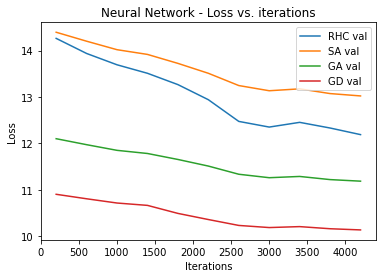

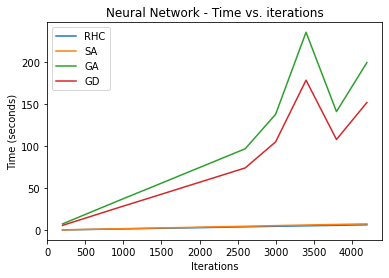

In [31]:
plot_nn_performances(x_train, y_train,
                            random_seeds=random_seeds,
                            rhc_max_iters=iterations, sa_max_iters=iterations,
                            ga_max_iters=iterations, gd_max_iters=iterations,
                            init_temp=100, exp_decay_rate=0.05, min_temp=0.001,
                            pop_size=100, mutation_prob=0.2)


In [33]:
def test_nn_performances(x_train, x_test, y_train, y_test, random_seed, **kwargs):
    """Test Neural Networks performances on the test set using different optimizations algorithms: RHC, SA, GA and GD.
        Args:
        x_train (ndarray): training data.
        x_test (ndarray): test data.
        y_train (ndarray): training labels.
        y_test (ndarray): test labels.
        random_seed (int): random seed.
        kwargs (dict): additional arguments to pass for curves plotting:
                   - max_iters (int): maximum number of iterations.
                   - init_temp (float): SA initial temperature.
                   - exp_decay_rate (float): SA temperature exponential decay rate.
                   - min_temp (float): SA minimum temperature.
                   - pop_size (int): GA population size.
                   - mutation_prob (float): GA mutation probability.
        Returns:
        None.
        """

    # Define SA exponential decay schedule
    exp_decay = ExpDecay(init_temp=kwargs['init_temp'],
                         exp_const=kwargs['exp_decay_rate'],
                         min_temp=kwargs['min_temp'])

    # Define Neural Network using RHC for weights optimization
    rhc_nn = NeuralNetwork(hidden_nodes=[2], activation='relu',
                           algorithm='random_hill_climb', max_iters=kwargs['max_iters'],
                           bias=True, is_classifier=True, learning_rate=0.001,
                           early_stopping=False, clip_max=1e10,
                           max_attempts=kwargs['max_iters'], random_state=random_seed, curve=False)

    # Define Neural Network using SA for weights optimization
    sa_nn = NeuralNetwork(hidden_nodes=[2], activation='relu',
                          algorithm='simulated_annealing', max_iters=kwargs['max_iters'],
                          bias=True, is_classifier=True, learning_rate=0.001,
                          early_stopping=False, clip_max=1e10, schedule=exp_decay,
                          max_attempts=kwargs['max_iters'], random_state=random_seed, curve=False)

    # Define Neural Network using GA for weights optimization
    ga_nn = NeuralNetwork(hidden_nodes=[2], activation='relu',
                          algorithm='genetic_alg', max_iters=kwargs['max_iters'],
                          bias=True, is_classifier=True, learning_rate=0.001,
                          early_stopping=False, clip_max=1e10,
                          pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                          max_attempts=kwargs['max_iters'], random_state=random_seed, curve=False)

    # Define Neural Network using GD for weights optimization
    gd_nn = NeuralNetwork(hidden_nodes=[2], activation='relu',
                          algorithm='gradient_descent', max_iters=kwargs['max_iters'],
                          bias=True, is_classifier=True, learning_rate=0.001,
                          early_stopping=False, clip_max=1e10,
                          max_attempts=kwargs['max_iters'], random_state=random_seed, curve=False)

    # Fit each of the Neural Networks using the different optimization algorithms
    rhc_nn.fit(x_train, y_train)
    sa_nn.fit(x_train, y_train)
    ga_nn.fit(x_train, y_train)
    gd_nn.fit(x_train, y_train)

    # Print classification reports for all of the optimization algorithms
    print('RHC test classification report = \n {}'.format(classification_report(y_test, rhc_nn.predict(x_test))))
    print('SA test classification report = \n {}'.format(classification_report(y_test, sa_nn.predict(x_test))))
    print('GA test classification report = \n {}'.format(classification_report(y_test, ga_nn.predict(x_test))))
    print('GD test classification report = \n {}'.format(classification_report(y_test, gd_nn.predict(x_test))))

In [35]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=100,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=10,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=100,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.01,
                    min_temp=0.001,pop_size=100,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       326
           1       0.00      0.00      0.00        58
           2       0.51      0.52      0.52        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.44      0.49      0.46       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.05,
                    min_temp=0.01,pop_size=100,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       326
           1       0.00      0.00      0.00        58
           2       0.51      0.52      0.52        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.44      0.49      0.46       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=300,exp_decay_rate=0.05,
                    min_temp=0.01,pop_size=100,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       326
           1       0.00      0.00      0.00        58
           2       0.51      0.52      0.52        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.44      0.49      0.46       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=50,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=100,mutation_prob=0.01)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=100,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=100,mutation_prob=0.2)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=10,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=200,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=10,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=10,mutation_prob=0.1)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
test_nn_performances(x_train, x_test, y_train, y_test, random_seed=21, 
                    max_iters=3000,init_temp=50,exp_decay_rate=0.05,
                    min_temp=0.001,pop_size=50,mutation_prob=0.01)

RHC test classification report = 
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       326
           1       0.00      0.00      0.00        58
           2       0.88      0.36      0.51        42

   micro avg       0.80      0.80      0.80       426
   macro avg       0.56      0.45      0.46       426
weighted avg       0.69      0.80      0.72       426
 samples avg       0.80      0.80      0.80       426

SA test classification report = 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86       326
           1       0.00      0.00      0.00        58
           2       0.50      0.50      0.50        42

   micro avg       0.77      0.77      0.77       426
   macro avg       0.43      0.48      0.45       426
weighted avg       0.66      0.77      0.71       426
 samples avg       0.77      0.77      0.77       426

GA test classification report = 
               precision    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
def plot_nn_performances1(x_train, y_train, random_seeds, **kwargs):
    """Plot Neural Networks performances on the training set.
        Use different optimizations algorithms (RHC, SA, GA and GD) and compare results on the training set using
        k-fold cross-validation.
        Args:
        x_train (ndarray): training data.
        y_train (ndarray): training labels.
        random_seeds (list or array): random seeds for multiple random runs to use for k-fold cross-validation.
        kwargs (dict): additional arguments to pass for curves plotting:
                  - rhc_max_iters (list or ndarray): RHC list or array of maximum number of iterations to plot vs.
                  - sa_max_iters (list or ndarray): SA list or array of maximum number of iterations to plot vs.
                  - ga_max_iters (list or ndarray): GA list or array of maximum number of iterations to plot vs.
                  - gd_max_iters (list or ndarray): GD list or array of maximum number of iterations to plot vs.
                  - init_temp (float): SA initial temperature.
                  - exp_decay_rate (float): SA temperature exponential decay rate.
                  - min_temp (float): SA minimum temperature.
                  - pop_size (int): GA population size.
                  - mutation_prob (float): GA mutation probability.
        Returns:
        None.
           """

    # Initialize algorithms, corresponding acronyms and max number of iterations
    algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'gradient_descent']
    acronyms = ['RHC', 'SA', 'GA', 'GD']
    max_iters = ['rhc_max_iters', 'sa_max_iters', 'ga_max_iters', 'gd_max_iters']

    # Initialize lists of training curves, validation curves and training times curves
    train_curves, val_curves, train_time_curves = [], [], []

    # Define SA exponential decay schedule
    exp_decay = ExpDecay(init_temp=kwargs['init_temp'],
                         exp_const=kwargs['exp_decay_rate'],
                         min_temp=kwargs['min_temp'])

    # Create one figure for training and validation losses, the second for training time
    plt.figure()
    train_val_figure = plt.gcf().number
    plt.figure()
    train_times_figure = plt.gcf().number

    # For each of the optimization algorithms to test the Neural Network with
    for i, algorithm in enumerate(algorithms):
        print('\nAlgorithm = {}'.format(algorithm))

        # For multiple random runs
        for random_seed in random_seeds:

            # Initialize training losses, validation losses and training time lists for current random run
            train_losses, val_losses, train_times = [], [], []

            # Compute stratified k-fold
            x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(x_train, y_train,
                                                                                  test_size=0.2, shuffle=True,
                                                                                  random_state=random_seed,
                                                                                  stratify=y_train)
            # For each max iterations to run for
            for max_iter in kwargs[max_iters[i]]:

                # Define Neural Network using current algorithm
                nn = NeuralNetwork(hidden_nodes=[5], activation='relu',
                                   algorithm=algorithm, max_iters=int(max_iter),
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=False, clip_max=1e10, schedule=exp_decay,
                                   pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                                   max_attempts=int(max_iter), random_state=random_seed, curve=False)

                # Train on current training fold and append training time
                start_time = time.time()
                nn.fit(x_train_fold, y_train_fold)
                train_times.append(time.time() - start_time)

                # Compute and append training and validation log losses
                train_loss = log_loss(y_train_fold, nn.predict(x_train_fold))
                val_loss = log_loss(y_val_fold, nn.predict(x_val_fold))
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(max_iter, train_loss, val_loss))

            # Append curves for current random seed to corresponding lists of curves
            train_curves.append(train_losses)
            val_curves.append(val_losses)
            train_time_curves.append(train_times)
        
        print('train_loss:',train_loss)
        print('train_curves:',train_curves)
        print('val_curves:',val_curves)
        print('train_time_curves:',train_time_curves)
        
        # Plot training and validation figure for current algorithm
        plt.figure(train_val_figure)
        utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(train_curves), label='{} train'.format(acronyms[i]))
        utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(val_curves), label='{} val'.format(acronyms[i]))

        # Plot training time figure for current algorithm
        plt.figure(train_times_figure)
        utils.plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(train_time_curves), label=acronyms[i])

    # Set title and labels to training and validation figure
    plt.figure(train_val_figure)
    utils.set_plot_title_labels(title='Neural Network - Loss vs. iterations',
                                x_label='Iterations',
                                y_label='Loss')

    # Save figure
    plt.savefig(outputs_path + 'nn_objective_vs_iterations')

    # Set title and labels to training time figure
    plt.figure(train_times_figure)
    utils.set_plot_title_labels(title='Neural Network - Time vs. iterations',
                                x_label='Iterations',
                                y_label='Time (seconds)')

    # Save figure
    plt.savefig(outputs_path + 'nn_time_vs_iterations')


Algorithm = random_hill_climb
200 - train loss = 30.983, val loss = 30.882
600 - train loss = 30.933, val loss = 30.882
1000 - train loss = 30.907, val loss = 30.882
1400 - train loss = 30.907, val loss = 30.882
1800 - train loss = 30.907, val loss = 30.780
2200 - train loss = 30.933, val loss = 30.577
2600 - train loss = 30.907, val loss = 30.679
3000 - train loss = 30.831, val loss = 30.577
3400 - train loss = 30.755, val loss = 30.780
3800 - train loss = 30.729, val loss = 30.780
4200 - train loss = 30.653, val loss = 30.882
200 - train loss = 7.924, val loss = 7.720
600 - train loss = 7.974, val loss = 7.720
1000 - train loss = 7.949, val loss = 7.720
1400 - train loss = 7.924, val loss = 7.619
1800 - train loss = 7.873, val loss = 7.619
2200 - train loss = 7.847, val loss = 7.416
2600 - train loss = 7.822, val loss = 7.314
3000 - train loss = 7.797, val loss = 7.314
3400 - train loss = 7.720, val loss = 7.314
3800 - train loss = 7.720, val loss = 7.314
4200 - train loss = 7.746, 

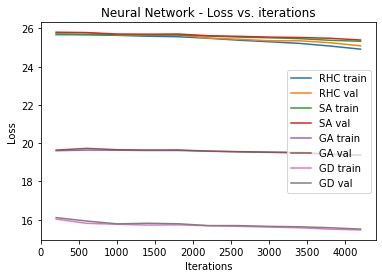

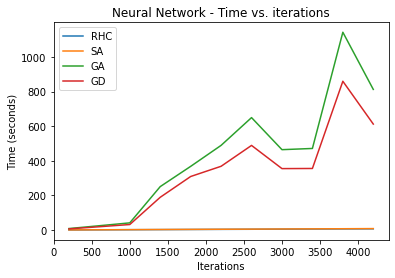

In [47]:
plot_nn_performances1(x_train, y_train,
                            random_seeds=random_seeds,
                            rhc_max_iters=iterations, sa_max_iters=iterations,
                            ga_max_iters=iterations, gd_max_iters=iterations,
                            init_temp=100, exp_decay_rate=0.05, min_temp=0.001,
                            pop_size=100, mutation_prob=0.2)